# Análise da clusterização das notícias

## Imports, definição de funções e carregamento dos dados

In [1]:
from b_limpar.limpador import Limpador
from b_vetorizar.vetorizador import Vetorizador
from c_clusterizar_por_texto.clusterizador_textual import ClusterizadorTextual
from c_clusterizar_por_texto.otimizador_clusterizacao_textual import OtimizadorClusterizacaoTextual
from _common import util
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd

noticias_df = util.carregar_todas_as_noticias() 
Limpador().limpar_se_necessario(noticias_df)
vetorizador = Vetorizador()
clusterizador = ClusterizadorTextual()
otimizador = OtimizadorClusterizacaoTextual(vetorizador, clusterizador, noticias_df)

Carregando todas as notícias


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Edson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Impacto do epsilon sobre a clusterização

Como se pode observar no gráfico abaixo à esquerda, conforme aumenta o valor do hiperparâmetro epsilon, é incrementado o número de clusters, porém até certo ponto; a partir de um certo valor de epsilon, o número de clusters diminui. 

O gráfico direita mostra que, enquanto o número de outliers diminui, aumenta o número de itens agrupados num supercluster. Isso reflete o que ocorre no gráfico da esquerda: quando o epsilon passa do valor que produz o maior número de clusters, esse supercluster começa a "engolir" um grande número de itens até predominar.

O código da primeira célula abaixo executa a clusterização para uma faixa de valores de epsilon. Para o teste, foi utilizado o modelo Word2vec sem inclusão do resumo. O código da segunda célula abaixo gera os gráfico que relacionam o epsilon ao número de clusters, ao número de outliers e ao número de itens agrupados no maior cluster. 

In [18]:
vetorizador.vetorizar_word2vec(noticias_df, usar_texto_limpo=True, incluir_resumo=False)
num_classes = {}
num_outliers = {}
num_itens_na_maior_classe = {}
for eps in np.arange(0.01, 2.00, 0.01):
    clusterizador.clusterizar(noticias_df, epsilon = eps, min_samples=4)
    counter = Counter(noticias_df['assunto'])
    num_classes.update({eps: len(counter.items())})
    num_outliers.update({eps: counter.get(-1)})
    num_itens_na_maior_classe.update({eps: max({k: v for k, v in counter.items() if k != None and k > -1}.values())})

Baixando modelo Word2Vec
Carregando modelo Word2Vec
Vetorizando com Word2Vec


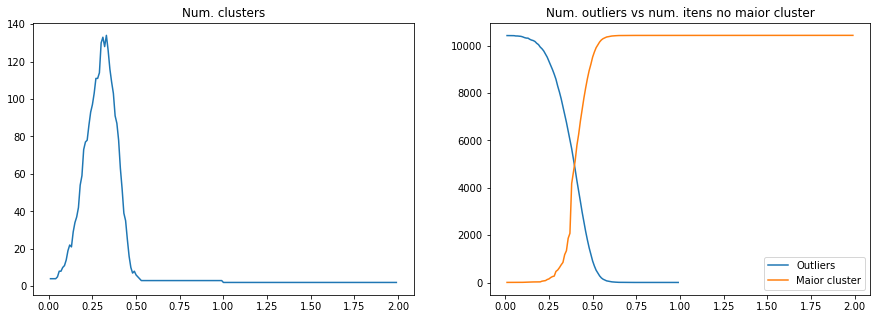

In [21]:
figure, axis = plt.subplots(1, 2)
axis[0].plot(list(num_classes.keys()), list(num_classes.values()))
axis[0].set_title("Num. clusters")
axis[1].plot(list(num_outliers.keys()), list(num_outliers.values()), label="Outliers")
axis[1].plot(list(num_itens_na_maior_classe.keys()), list(num_itens_na_maior_classe.values()), label="Maior cluster")
axis[1].set_title("Num. outliers vs num. itens no maior cluster")
axis[1].legend(loc="lower right")
plt.show()
plt.rcParams['figure.figsize'] = [15, 5]

## Busca pelos melhores hiperparâmetros

A célula abaixo faz uma busca bayesiana pelos cruzamentos de cenários e valores de hiperparâmetros possíveis: 
- Usar texto limpo: True, False
- Incluir o resumo ao vetorizar: True, False
- Modelo de linguagem: USE, SBERT, WORD2VEC
- Hiperparâmetro epsilon: escala de 0.01 a 2.00

Considerando que se deseja agrupar itens que sejam realmente similares e levando em conta o comportamento do número de clusters exibido no gráfico acima, decidiu-se priorizar a combinação de valores que resulte no maior número de clusters.

In [2]:
resultado = otimizador.executar()

Baixando e carregando modelo Google USE
Vetorizando com Google USE
100%|██████████| 100/100 [05:40<00:00,  3.40s/trial, best loss: -77.0]
Vetorizando com Google USE
100%|██████████| 100/100 [05:56<00:00,  3.56s/trial, best loss: -60.0]
Vetorizando com Google USE
100%|██████████| 100/100 [06:08<00:00,  3.69s/trial, best loss: -41.0]
Vetorizando com Google USE
100%|██████████| 100/100 [06:07<00:00,  3.67s/trial, best loss: -50.0]
Baixando e carregando modelo SBERT
Vetorizando com SBERT
100%|██████████| 100/100 [05:22<00:00,  3.22s/trial, best loss: -133.0]
Vetorizando com SBERT
100%|██████████| 100/100 [05:32<00:00,  3.33s/trial, best loss: -146.0]
Vetorizando com SBERT
100%|██████████| 100/100 [05:30<00:00,  3.30s/trial, best loss: -111.0]
Vetorizando com SBERT
100%|██████████| 100/100 [05:18<00:00,  3.19s/trial, best loss: -167.0]
Baixando modelo Word2Vec
Carregando modelo Word2Vec
Vetorizando com Word2Vec
100%|██████████| 100/100 [03:38<00:00,  2.18s/trial, best loss: -102.0]
Vetoriza

In [3]:
resultado

,modelo_linguagem,usar_texto_limpo,incluir_resumo,melhor_epsilon,melhor_metric,maior_num_classes
0,USE,True,True,0.123097,cosine,77.0
1,USE,True,False,0.189706,cosine,60.0
2,USE,False,True,0.064859,cosine,41.0
3,USE,False,False,0.126351,cosine,50.0
4,SBERT,True,True,0.302612,cosine,133.0
5,SBERT,True,False,0.306983,cosine,146.0
6,SBERT,False,True,0.267518,cosine,111.0
7,SBERT,False,False,0.341808,cosine,167.0
8,WORD2VEC,True,True,0.110499,cosine,102.0
9,WORD2VEC,True,False,0.331829,cosine,133.0


## Visualização dos clusters

A célula abaixo salva no arquivo resultado_clusterizacao_textual.csv (e também exibe no output) os títulos das notícias e seus respectivos clusters. Os itens classificados como -1 são outliers. Os de classe vazia foram ignorados na clusterização por terem sido marcados como ignorados na etapa de limpeza. 

In [4]:
vetorizador.vetorizar_sbert(noticias_df, usar_texto_limpo=False, incluir_resumo=False)
ClusterizadorTextual().clusterizar(noticias_df, epsilon = 0.341808	, min_samples=4, metric='cosine')
noticias_clusterizadas_df = noticias_df[['assunto', 'data_publ', 'titulo']].copy()
noticias_clusterizadas_df.sort_values('assunto', ascending=False, inplace=True)
noticias_clusterizadas_df.to_csv('resultado_clusterizacao_textual.csv', index=False)
noticias_clusterizadas_df

Vetorizando com SBERT


,assunto,data_publ,titulo
10890,164,2022-10-05 12:23:32,Pai e filho brasileiros são presos nos EUA por...
11049,164,2022-10-05 12:05:55,Brasileiros são presos nos EUA acusados de con...
10900,164,2022-10-05 00:38:36,Brasileiro suspeito de agir como 'coiote' é in...
10028,164,2022-05-24 22:00:31,Brasileiro é preso depois de ameaçar explodir ...
6759,164,2022-05-16 18:11:06,Família de brasileiros abandona EUA devido a u...
...,...,...,...
10841,None,2022-10-05 16:32:44,As histórias de jovens mortas nas manifestaçõe...
10833,None,2022-10-05 16:40:36,"VÍDEOS: AB1 de quarta-feira, 5 de outubro"
10825,None,2022-10-05 16:50:02,"VÍDEOS: EPTV 1 Sul de Minas de quarta-feira, 5..."
11030,None,2022-10-05 17:38:47,"VÍDEOS: JL1 desta quarta-feira, 5 de outubro d..."


Exemplo de cluster: privatização da Eletrobrás:

In [12]:
noticias_eletrobras_df = noticias_df.loc[noticias_df['assunto'] == 144][['assunto', 'data_publ', 'titulo']].copy()
noticias_eletrobras_df.sort_values('data_publ', ascending=False, inplace=True)
pd.set_option('display.max_colwidth', None)
noticias_eletrobras_df

,assunto,data_publ,titulo
10620,144,2022-05-27 22:18:00,Oferta pública de ações dá início à privatização da Eletrobras
10165,144,2022-05-27 13:17:04,Eletrobras lança oferta de ações para privatização da companhia
9608,144,2022-05-23 07:00:00,Quais são os próximos passos para a privatização da Eletrobras?
8850,144,2022-05-21 07:00:00,"Vale comprar ações da Eletrobras, após aprovação de privatização pelo TCU?"
8023,144,2022-05-19 16:16:13,Eletrobras sobe após TCU aprovar privatização; é bom para o investidor?
7959,144,2022-05-19 03:17:08,TCU aprova processo de privatização da Eletrobras
7952,144,2022-05-18 21:50:33,TCU forma maioria para aprovar privatização da Eletrobras
7857,144,2022-05-18 20:25:36,"Por 7 votos a 1, TCU aprova processo de privatização da Eletrobras"
7860,144,2022-05-18 19:08:15,Ministro do TCU Vital do Rêgo vota contra privatização da Eletrobras
